In [1]:
# Just ignore this shit
import sys
!{sys.executable} -m pip install openpyxl
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install statsmodels
!{sys.executable} -m pip install seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
import seaborn as sns
import warnings
import math
import scipy.stats as stats
import scipy
from sklearn.preprocessing import scale
from sklearn import preprocessing

%matplotlib inline

In [2]:
# starts here
hr_data = pd.read_csv("HR_data.csv")
    
# Just printing the data, to visualize better
print ("HR Data size:", len(hr_data))

HR Data size: 10098


In [3]:
# I'm going to make a method to return only the wanted columns from the data set
# I'll probably re use it a couple of times, so instead of copy paste, ...
list_of_cols = ['All Turnover', 'Gender key', 'Text', 'Pay scale group (Level)','Pay scale text', 'Firm Tenure days']

def trim_data(hr_data):
    return hr_data[list_of_cols]

# For the future columns, that i'm going to create, 
# this method will just add whatever column passed to the list of viewed columns
def add_to_cols(col):
    list_of_cols.append(col) if col not in list_of_cols else list_of_cols

# Just calling that method!
trim_data(hr_data).head(10)

,All Turnover,Gender key,Text,Pay scale group (Level),Pay scale text,Firm Tenure days
0,0,Male,Black / African American,14,Exempt,15129.0
1,0,Male,White,15,Exempt,14659.0
2,0,Female,Black / African American,8,Non-Exempt,14593.0
3,1,Male,Black / African American,11,Non-Exempt,13624.0
4,0,Female,White,14,Exempt,13456.0
5,0,Male,White,11,Non-Exempt,13363.0
6,0,Female,White,14,Exempt,13239.0
7,0,Male,White,13,Exempt,13140.0
8,0,Male,White,16,Exempt,12497.0
9,0,Male,I choose not to identify,11,Non-Exempt,12495.0


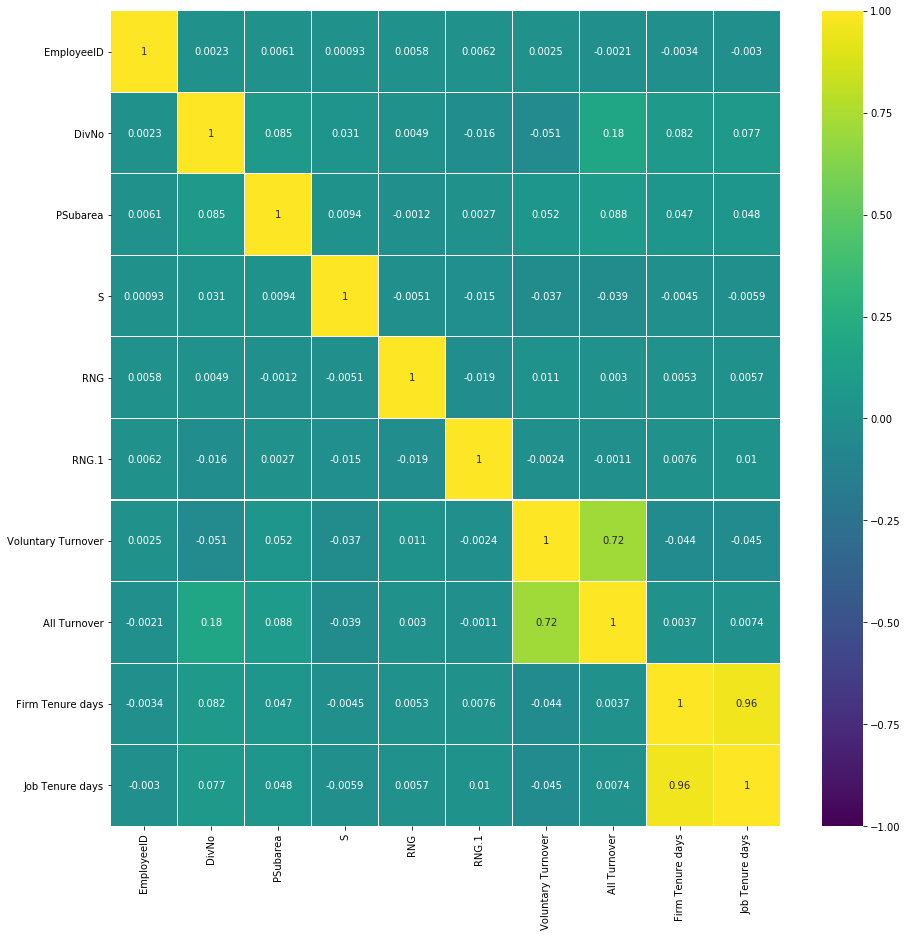

In [4]:
# We can print correlations of each field with other fields and try to find if there are any 2 very correlated fields ..
# (This is just for curiosity)
plt.figure(figsize=(15,15))
sns.heatmap(hr_data.corr(), vmin=-1, vmax=1, cmap="viridis", annot=True, linewidth=0.1)

In [5]:
# Doing some checks on the data, here we check if there are any null values anywhere
hr_data.isnull().sum()

EmployeeID                  0
DivNo                       0
DIV                         0
PSubarea                    0
PS text                     0
ESgrp                       0
Name of ES                  0
S                           0
Name                        0
Location                    0
Pay scale text              0
Gender key                  0
Pay scale group (Level)    10
Current Hire Date           0
Original Hire Date          1
Text                       60
RNG                         0
RNG.1                       0
Voluntary Turnover          0
All Turnover                0
Report date                 0
Firm Tenure days            1
Job Tenure days             0
dtype: int64

In [6]:
#Since the null values of "Text" and "Payscale group" are actually used in the model, we should just drop them
# It's only 60 + 10 rows out of 10,000 so shouldn't change much
hr_data.dropna(inplace=True)
len(hr_data)

10028

In [7]:
# Let's start cleaning the data, first we'll replace the gender key column with binary values
hr_data['Gender'] = np.where(hr_data['Gender key'] == 'Female', 1, 0)

# Add the new column, to the list of trimmed viewed columns
add_to_cols('Gender')

# Just calling my method from earlier hehe
trim_data(hr_data).head(10)

,All Turnover,Gender key,Text,Pay scale group (Level),Pay scale text,Firm Tenure days,Gender
0,0,Male,Black / African American,14,Exempt,15129.0,0
1,0,Male,White,15,Exempt,14659.0,0
2,0,Female,Black / African American,8,Non-Exempt,14593.0,1
3,1,Male,Black / African American,11,Non-Exempt,13624.0,0
4,0,Female,White,14,Exempt,13456.0,1
5,0,Male,White,11,Non-Exempt,13363.0,0
6,0,Female,White,14,Exempt,13239.0,1
7,0,Male,White,13,Exempt,13140.0,0
8,0,Male,White,16,Exempt,12497.0,0
9,0,Male,I choose not to identify,11,Non-Exempt,12495.0,0


In [8]:
# Next let's replace every non-white person with 0, and white people as 1
hr_data['Racial Cat White'] = np.where(hr_data['Text'] == 'White', 1, 0)

# Add the new column, to the list of trimmed viewed columns
add_to_cols('Racial Cat White')

#Then to see wtf we just did, we use my method from earlier
trim_data(hr_data).head(10)

,All Turnover,Gender key,Text,Pay scale group (Level),Pay scale text,Firm Tenure days,Gender,Racial Cat White
0,0,Male,Black / African American,14,Exempt,15129.0,0,0
1,0,Male,White,15,Exempt,14659.0,0,1
2,0,Female,Black / African American,8,Non-Exempt,14593.0,1,0
3,1,Male,Black / African American,11,Non-Exempt,13624.0,0,0
4,0,Female,White,14,Exempt,13456.0,1,1
5,0,Male,White,11,Non-Exempt,13363.0,0,1
6,0,Female,White,14,Exempt,13239.0,1,1
7,0,Male,White,13,Exempt,13140.0,0,1
8,0,Male,White,16,Exempt,12497.0,0,1
9,0,Male,I choose not to identify,11,Non-Exempt,12495.0,0,0


In [9]:
# Now what imma do is create a new column for Overtime Non Exempt
hr_data['Overtime Non Exempt'] = np.where(hr_data['Pay scale text'] == 'Non-Exempt', 1, 0)

# Add the new column, to the list of trimmed viewed columns
add_to_cols('Overtime Non Exempt')

# Call dat method, to view if our shit worked or not
trim_data(hr_data).head(10)

,All Turnover,Gender key,Text,Pay scale group (Level),Pay scale text,Firm Tenure days,Gender,Racial Cat White,Overtime Non Exempt
0,0,Male,Black / African American,14,Exempt,15129.0,0,0,0
1,0,Male,White,15,Exempt,14659.0,0,1,0
2,0,Female,Black / African American,8,Non-Exempt,14593.0,1,0,1
3,1,Male,Black / African American,11,Non-Exempt,13624.0,0,0,1
4,0,Female,White,14,Exempt,13456.0,1,1,0
5,0,Male,White,11,Non-Exempt,13363.0,0,1,1
6,0,Female,White,14,Exempt,13239.0,1,1,0
7,0,Male,White,13,Exempt,13140.0,0,1,0
8,0,Male,White,16,Exempt,12497.0,0,1,0
9,0,Male,I choose not to identify,11,Non-Exempt,12495.0,0,0,1


In [10]:
# Now we can add the Overtime Sales column, it's like 99.999999999% same code as above
hr_data['Overtime Sales'] = np.where(hr_data['Pay scale text'] == 'Sales', 1, 0)

# Add that column to be viewed
add_to_cols('Overtime Sales')

# Call the method, to see wtf happned
trim_data(hr_data).head(2500)

,All Turnover,Gender key,Text,Pay scale group (Level),Pay scale text,Firm Tenure days,Gender,Racial Cat White,Overtime Non Exempt,Overtime Sales
0,0,Male,Black / African American,14,Exempt,15129.0,0,0,0,0
1,0,Male,White,15,Exempt,14659.0,0,1,0,0
2,0,Female,Black / African American,8,Non-Exempt,14593.0,1,0,1,0
3,1,Male,Black / African American,11,Non-Exempt,13624.0,0,0,1,0
4,0,Female,White,14,Exempt,13456.0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...
2497,0,Male,White,16,Sales,3974.0,0,1,0,1
2498,0,Male,White,16,Sales,3974.0,0,1,0,1
2499,0,Female,White,14,Sales,3974.0,1,1,0,1
2500,0,Male,White,18,Sales,3971.0,0,1,0,1


In [11]:
# Now we can add the Overtime Sales column, it's like 99.999999999% same code as above
hr_data['Overtime Union'] = np.where(hr_data['Pay scale text'] == 'Union', 1, 0)

# Add that column to be viewed
add_to_cols('Overtime Union')

# Call the method, to see wtf happned
trim_data(hr_data).tail(3450)

,All Turnover,Gender key,Text,Pay scale group (Level),Pay scale text,Firm Tenure days,Gender,Racial Cat White,Overtime Non Exempt,Overtime Sales,Overtime Union
6633,0,Male,White,M4,Union,12745.0,0,1,0,0,1
6634,0,Female,White,U4,Union,12728.0,1,1,0,0,1
6635,0,Male,White,M4,Union,12727.0,0,1,0,0,1
6636,0,Female,Asian,20,Exempt,12686.0,1,0,0,0,0
6637,1,Female,White,U4,Union,12672.0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
10093,1,Male,White,15,Exempt,702.0,0,1,0,0,0
10094,1,Female,Asian,12,Non-Exempt,520.0,1,0,1,0,0
10095,1,Female,Black / African American,12,Non-Exempt,520.0,1,0,1,0,0
10096,1,Male,White,15,Exempt,492.0,0,1,0,0,0


In [12]:
# So I saved the numeric / NonNumeric pay levels for the end cuz like seems the most tricky
# So anywaaaayz

# Here I had to convert the row into a number, before comparing it (between 1 and 26),
# So it's a little messier then the others but not too bad
hr_data['Numeric Pay Level'] = np.where(
    (pd.to_numeric(hr_data['Pay scale group (Level)'], errors='coerce').between(1, 26)), hr_data['Pay scale group (Level)'], 0)

# Add that column to be viewed
add_to_cols('Numeric Pay Level')

# Call the method, to see wtf happned
trim_data(hr_data).tail(400)

,All Turnover,Gender key,Text,Pay scale group (Level),Pay scale text,Firm Tenure days,Gender,Racial Cat White,Overtime Non Exempt,Overtime Sales,Overtime Union,Numeric Pay Level
9697,1,Female,White,14,Exempt,3992.0,1,1,0,0,0,14
9698,1,Male,White,507,Non-Exempt,3978.0,0,1,1,0,0,0
9699,1,Female,Black / African American,410,Non-Exempt,3936.0,1,0,1,0,0,0
9700,1,Male,White,14,Exempt,3922.0,0,1,0,0,0,14
9701,1,Female,White,109,Non-Exempt,3894.0,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10093,1,Male,White,15,Exempt,702.0,0,1,0,0,0,15
10094,1,Female,Asian,12,Non-Exempt,520.0,1,0,1,0,0,12
10095,1,Female,Black / African American,12,Non-Exempt,520.0,1,0,1,0,0,12
10096,1,Male,White,15,Exempt,492.0,0,1,0,0,0,15


In [13]:
# So for the next part, I guess i'm going to label encode the NonNumeric Values ???
# So lemme first check how many values we're talking about here
len(hr_data.loc[hr_data['Numeric Pay Level'] == 0])

616

In [14]:
#I guess i'm going to make the new column first, and then label encode it afterwards
hr_data['Non Numeric Pay Level'] = np.where(hr_data['Numeric Pay Level'] == 0, hr_data['Pay scale group (Level)'], "N/A")

# Add that column to be viewed
add_to_cols('Non Numeric Pay Level')

# Call the method, to see wtf happned
trim_data(hr_data).head(7220)

,All Turnover,Gender key,Text,Pay scale group (Level),Pay scale text,Firm Tenure days,Gender,Racial Cat White,Overtime Non Exempt,Overtime Sales,Overtime Union,Numeric Pay Level,Non Numeric Pay Level
0,0,Male,Black / African American,14,Exempt,15129.0,0,0,0,0,0,14,N/A
1,0,Male,White,15,Exempt,14659.0,0,1,0,0,0,15,N/A
2,0,Female,Black / African American,8,Non-Exempt,14593.0,1,0,1,0,0,8,N/A
3,1,Male,Black / African American,11,Non-Exempt,13624.0,0,0,1,0,0,11,N/A
4,0,Female,White,14,Exempt,13456.0,1,1,0,0,0,14,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7270,0,Male,White,U3,Union,1829.0,0,1,0,0,1,0,U3
7271,0,Male,White,U3,Union,1829.0,0,1,0,0,1,0,U3
7272,0,Male,White,12,Non-Exempt,1821.0,0,1,1,0,0,12,N/A
7273,0,Male,White,15,Exempt,1821.0,0,1,0,0,0,15,N/A


In [15]:
# Label encode the column! :p (Basically it will transform the column, into unique values instead of whatever it was)
label_encoder = preprocessing.LabelEncoder()
hr_data['Non Numeric Pay Level'] = label_encoder.fit_transform(hr_data['Non Numeric Pay Level'])

# Call the method, to see wtf happned
trim_data(hr_data).head(7220)

,All Turnover,Gender key,Text,Pay scale group (Level),Pay scale text,Firm Tenure days,Gender,Racial Cat White,Overtime Non Exempt,Overtime Sales,Overtime Union,Numeric Pay Level,Non Numeric Pay Level
0,0,Male,Black / African American,14,Exempt,15129.0,0,0,0,0,0,14,38
1,0,Male,White,15,Exempt,14659.0,0,1,0,0,0,15,38
2,0,Female,Black / African American,8,Non-Exempt,14593.0,1,0,1,0,0,8,38
3,1,Male,Black / African American,11,Non-Exempt,13624.0,0,0,1,0,0,11,38
4,0,Female,White,14,Exempt,13456.0,1,1,0,0,0,14,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7270,0,Male,White,U3,Union,1829.0,0,1,0,0,1,0,40
7271,0,Male,White,U3,Union,1829.0,0,1,0,0,1,0,40
7272,0,Male,White,12,Non-Exempt,1821.0,0,1,1,0,0,12,38
7273,0,Male,White,15,Exempt,1821.0,0,1,0,0,0,15,38


In [16]:
# So I'm going to add the squares as well as seperate columns, and get rid of the useless columns now
hr_data['Firm Tenure days sq'] = np.square(hr_data['Firm Tenure days'])

# Add that column to be viewed
add_to_cols('Firm Tenure days sq')

# Check it outtt
trim_data(hr_data).head()

,All Turnover,Gender key,Text,Pay scale group (Level),Pay scale text,Firm Tenure days,Gender,Racial Cat White,Overtime Non Exempt,Overtime Sales,Overtime Union,Numeric Pay Level,Non Numeric Pay Level,Firm Tenure days sq
0,0,Male,Black / African American,14,Exempt,15129.0,0,0,0,0,0,14,38,228886641.0
1,0,Male,White,15,Exempt,14659.0,0,1,0,0,0,15,38,214886281.0
2,0,Female,Black / African American,8,Non-Exempt,14593.0,1,0,1,0,0,8,38,212955649.0
3,1,Male,Black / African American,11,Non-Exempt,13624.0,0,0,1,0,0,11,38,185613376.0
4,0,Female,White,14,Exempt,13456.0,1,1,0,0,0,14,38,181063936.0


In [17]:
# Adding the other square
hr_data['Numeric Pay Level sq'] = np.square(hr_data['Numeric Pay Level'].astype(int))

# Add that column to be viewed
add_to_cols('Numeric Pay Level sq')

# Check it outtt
trim_data(hr_data).head()

,All Turnover,Gender key,Text,Pay scale group (Level),Pay scale text,Firm Tenure days,Gender,Racial Cat White,Overtime Non Exempt,Overtime Sales,Overtime Union,Numeric Pay Level,Non Numeric Pay Level,Firm Tenure days sq,Numeric Pay Level sq
0,0,Male,Black / African American,14,Exempt,15129.0,0,0,0,0,0,14,38,228886641.0,196
1,0,Male,White,15,Exempt,14659.0,0,1,0,0,0,15,38,214886281.0,225
2,0,Female,Black / African American,8,Non-Exempt,14593.0,1,0,1,0,0,8,38,212955649.0,64
3,1,Male,Black / African American,11,Non-Exempt,13624.0,0,0,1,0,0,11,38,185613376.0,121
4,0,Female,White,14,Exempt,13456.0,1,1,0,0,0,14,38,181063936.0,196


In [18]:
# I'm going to make a new data set (X values), with just what I need
X_data = hr_data[['Firm Tenure days', 'Firm Tenure days sq', 'Gender', 'Racial Cat White', 'Numeric Pay Level', 'Numeric Pay Level sq', 'Non Numeric Pay Level', 'Overtime Non Exempt', 'Overtime Sales', 'Overtime Union']].astype(int)
X_data = sm.add_constant(X_data) # I added this to accomodate for B0
X_data.head()

,const,Firm Tenure days,Firm Tenure days sq,Gender,Racial Cat White,Numeric Pay Level,Numeric Pay Level sq,Non Numeric Pay Level,Overtime Non Exempt,Overtime Sales,Overtime Union
0,1.0,15129,228886641,0,0,14,196,38,0,0,0
1,1.0,14659,214886281,0,1,15,225,38,0,0,0
2,1.0,14593,212955649,1,0,8,64,38,1,0,0
3,1.0,13624,185613376,0,0,11,121,38,1,0,0
4,1.0,13456,181063936,1,1,14,196,38,0,0,0


In [19]:
# I'm also going to create my Y values
Y_data = hr_data['All Turnover']
Y_data.head()

0    0
1    0
2    0
3    1
4    0
Name: All Turnover, dtype: int64

In [21]:
# Finally we fit the model!!
results = sm.OLS(Y_data, X_data).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           All Turnover   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     76.22
Date:                Fri, 05 Feb 2021   Prob (F-statistic):          2.00e-151
Time:                        02:21:39   Log-Likelihood:                -3165.6
No. Observations:               10028   AIC:                             6353.
Df Residuals:                   10017   BIC:                             6433.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.0954      0.043     25.686      0.000       1.012       1.179
Firm Tenure days        -8.1e-06   3.26e-06     -2.488      0.013   -1.45e-05   -1.72e-06
Firm Tenure days sq    8.262e-10   2.87e-10      2.883      0.004    2.64e-10    1.39e-09
Gender                   -0.0041      0.007     -0.612      0.540      -0.017       0.009
Racial Cat White         -0.0008      0.008     -0.091      0.928      -0.017       0.016
Numeric Pay Level        -0.0839      0.007    -12.072      0.000      -0.098      -0.070
Numeric Pay Level sq      0.0024      0.000     10.240      0.000       0.002       0.003
Non Numeric Pay Level    -0.0056      0.002     -3.177      0.001      -0.009      -0.002
Overtime Non Exempt      -0.1389      0.016     -8.650      0.000      -0.170      -0.107
Overtime Sales           -0.0446      0.008     -5.671      0.000      -0.060      -0.029
Overtime Union           -0.8161      0.053    -15.515      0.000      -0.919      -0.713
==============================================================================
Omnibus:                     3916.240   Durbin-Watson:                   1.626
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11371.111
Skew:                           2.155   Prob(JB):                         0.00
Kurtosis:                       5.941   Cond. No.                     5.94e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.94e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
# I'm also going to create my Y2 values for Voluntary Turnover
Y2_data = hr_data['Voluntary Turnover']
Y2_data.head()

# Finally we fit the model!!
results = sm.OLS(Y2_data, X_data).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Voluntary Turnover   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     13.44
Date:                Fri, 05 Feb 2021   Prob (F-statistic):           8.76e-24
Time:                        02:22:57   Log-Likelihood:                -789.30
No. Observations:               10028   AIC:                             1601.
Df Residuals:                   10017   BIC:                             1680.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0192      0.034      0.571      0.568      -0.047       0.085
Firm Tenure days      -2.425e-05   2.57e-06     -9.440      0.000   -2.93e-05   -1.92e-05
Firm Tenure days sq     1.94e-09   2.26e-10      8.578      0.000     1.5e-09    2.38e-09
Gender                    0.0002      0.005      0.037      0.971      -0.010       0.011
Racial Cat White         -0.0106      0.007     -1.617      0.106      -0.023       0.002
Numeric Pay Level        -0.0154      0.005     -2.800      0.005      -0.026      -0.005
Numeric Pay Level sq      0.0006      0.000      3.133      0.002       0.000       0.001
Non Numeric Pay Level     0.0053      0.001      3.796      0.000       0.003       0.008
Overtime Non Exempt      -0.0145      0.013     -1.147      0.251      -0.039       0.010
Overtime Sales            0.0115      0.006      1.849      0.064      -0.001       0.024
Overtime Union           -0.1173      0.042     -2.827      0.005      -0.199      -0.036
==============================================================================
Omnibus:                     6308.184   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            44593.036
Skew:                           3.160   Prob(JB):                         0.00
Kurtosis:                      11.172   Cond. No.                     5.94e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.94e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""